# Problem 1: 

### You are hired by one of the leading news channels CNBE who wants to analyze recent elections. This survey was conducted on 1525 voters with 9 variables. You have to build a model, to predict which party a voter will vote for on the basis of the given information, to create an exit poll that will help in predicting overall win and seats covered by a particular party.


### Data Dictionary:

1. vote: Party choice: Conservative or Labour

2. age: in years

3. economic.cond.national: Assessment of current national economic conditions, 1 to 5.

4. economic.cond.household: Assessment of current household economic conditions, 1 to 5.

5. Blair: Assessment of the Labour leader, 1 to 5.

6. Hague: Assessment of the Conservative leader, 1 to 5.

7. Europe: an 11-point scale that measures respondents' attitudes toward European integration. High scores represent ‘Eurosceptic’ sentiment.

8. political.knowledge: Knowledge of parties' positions on European integration, 0 to 3.

9. gender: female or male.

## Problem Statement: 

### To predict which party a voter will vote for on the basis of the given information, to create an exit poll that will help in predicting overall win and seats covered by a particular party.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import tree, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,plot_confusion_matrix

# 1.1 Read the dataset. Do the descriptive statistics and do the null value condition check. Write an inference on it. 

In [8]:
df = pd.read_excel("Election_Data.xlsx",sheet_name="Election_Dataset_Two Classes")
df.head ()

,Unnamed: 0,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender
0,1,Labour,43,3,3,4,1,2,2,female
1,2,Labour,36,4,4,4,4,5,2,male
2,3,Labour,35,4,4,5,2,3,2,male
3,4,Labour,24,4,2,2,1,4,0,female
4,5,Labour,41,2,2,1,1,6,2,male


In [9]:
df.tail ()

,Unnamed: 0,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender
1520,1521,Conservative,67,5,3,2,4,11,3,male
1521,1522,Conservative,73,2,2,4,4,8,2,male
1522,1523,Labour,37,3,3,5,4,2,2,male
1523,1524,Conservative,61,3,3,1,4,11,2,male
1524,1525,Conservative,74,2,3,2,4,11,0,female


In [10]:
df= df.drop('Unnamed: 0',axis=1)
df.head()

,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender
0,Labour,43,3,3,4,1,2,2,female
1,Labour,36,4,4,4,4,5,2,male
2,Labour,35,4,4,5,2,3,2,male
3,Labour,24,4,2,2,1,4,0,female
4,Labour,41,2,2,1,1,6,2,male


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1525 entries, 0 to 1524
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   vote                     1525 non-null   object
 1   age                      1525 non-null   int64 
 2   economic.cond.national   1525 non-null   int64 
 3   economic.cond.household  1525 non-null   int64 
 4   Blair                    1525 non-null   int64 
 5   Hague                    1525 non-null   int64 
 6   Europe                   1525 non-null   int64 
 7   political.knowledge      1525 non-null   int64 
 8   gender                   1525 non-null   object
dtypes: int64(7), object(2)
memory usage: 107.4+ KB


The dataset contents 1525 observations across 10 columns in total. The first column is just a label and will not be used in the analysis. Hence, we dropped it. So, we remain with 9 columns to perform regression.

In [12]:
df.isnull().sum()

vote                       0
age                        0
economic.cond.national     0
economic.cond.household    0
Blair                      0
Hague                      0
Europe                     0
political.knowledge        0
gender                     0
dtype: int64

There are 7 continuous and 1 categorical variable of binary type apart from target variable of 'vote' which is also a binary type categorical variable. There are no missing values in the dataset as well. 

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1525.0,54.182295,15.711209,24.0,41.0,53.0,67.0,93.0
economic.cond.national,1525.0,3.245902,0.880969,1.0,3.0,3.0,4.0,5.0
economic.cond.household,1525.0,3.140328,0.929951,1.0,3.0,3.0,4.0,5.0
Blair,1525.0,3.334426,1.174824,1.0,2.0,4.0,4.0,5.0
Hague,1525.0,2.746885,1.230703,1.0,2.0,2.0,4.0,5.0
Europe,1525.0,6.728525,3.297538,1.0,4.0,6.0,10.0,11.0
political.knowledge,1525.0,1.542295,1.083315,0.0,0.0,2.0,2.0,3.0


We can see that average age of the voter is near 55 years. The data is observed to have almost similar mean and median values without any outliers which we will further evaluate during our analysis. Most of the voters share Eurosceptic sentiment with 75% of them standing at a scale of 10. However of these voters, there are about 25% without any political knowledge on European Integration.

## Check for Duplicate records

In [14]:
df.duplicated().sum()

8

In [15]:
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

df[dups]

Number of duplicate rows = 8


,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender
67,Labour,35,4,4,5,2,3,2,male
626,Labour,39,3,4,4,2,5,2,male
870,Labour,38,2,4,2,2,4,3,male
983,Conservative,74,4,3,2,4,8,2,female
1154,Conservative,53,3,4,2,2,6,0,female
1236,Labour,36,3,3,2,2,6,2,female
1244,Labour,29,4,4,4,2,2,2,female
1438,Labour,40,4,3,4,2,2,2,male


In [16]:
print('Before',df.shape)
df.drop_duplicates(inplace=True) 
print('After',df.shape)

Before (1525, 9)
After (1517, 9)


There are 8 duplicates and as informed these duplicates need to be dropped because they do not add any value to the study, be it associated with different people. So, we are now left with a dataset of 1517 attributes. 

In [17]:
columns= df.select_dtypes(include='object').columns
for i in columns:
    print('\n')
    print ("---- {} ----".format(i))
    print(pd.DataFrame([df[i].value_counts(),
                       round(df[i].value_counts()/df.shape[0]*100,2)],index=['Count','Percent']).T)
    print('\n')
        



---- vote ----
               Count  Percent
Labour        1057.0    69.68
Conservative   460.0    30.32




---- gender ----
        Count  Percent
female  808.0    53.26
male    709.0    46.74




We can observe, that the classes of response variable "vote" are decently balanced where labour class is (69.68 %) and the conservative class is (30.32 %).  

Also, there is a decent mix of both male (53.26 %) and female (46.74%) voters. 

As a rule of thumb, class imbalance doesn't significantly harm performance in cases where the minority class makes up 10% or more of the dataset. Hence, we can confirm that there is no class imbalance in the data.

# 1.2 Perform Univariate and Bivariate Analysis. Do exploratory data analysis. Check for Outliers. 

## Univariate Analysis

In [18]:
cont = df.select_dtypes(include = ['int64'])
lstnumericcolumns = list(cont.columns.values)
len(lstnumericcolumns)

7

age
Skew: 0.14


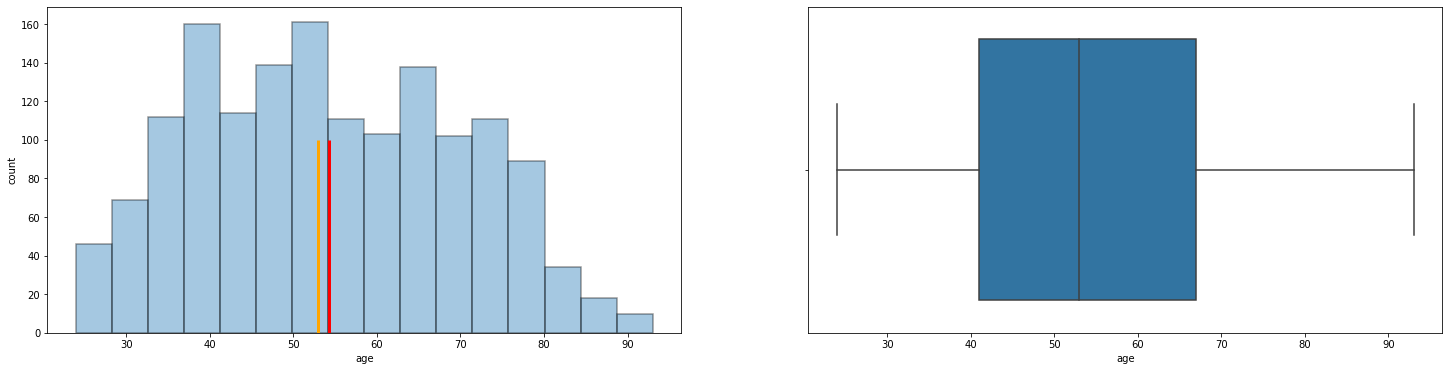

economic.cond.national
Skew: -0.24


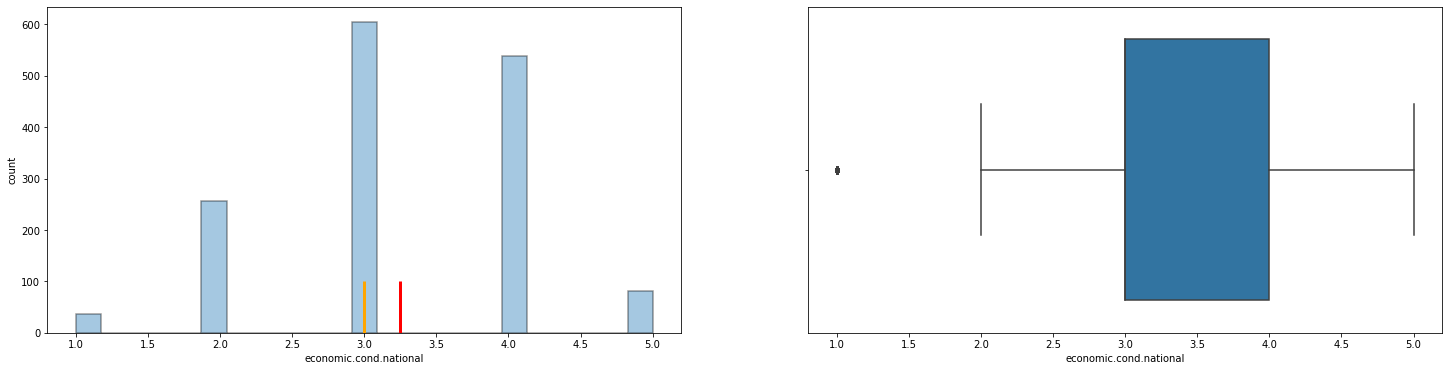

economic.cond.household
Skew: -0.14


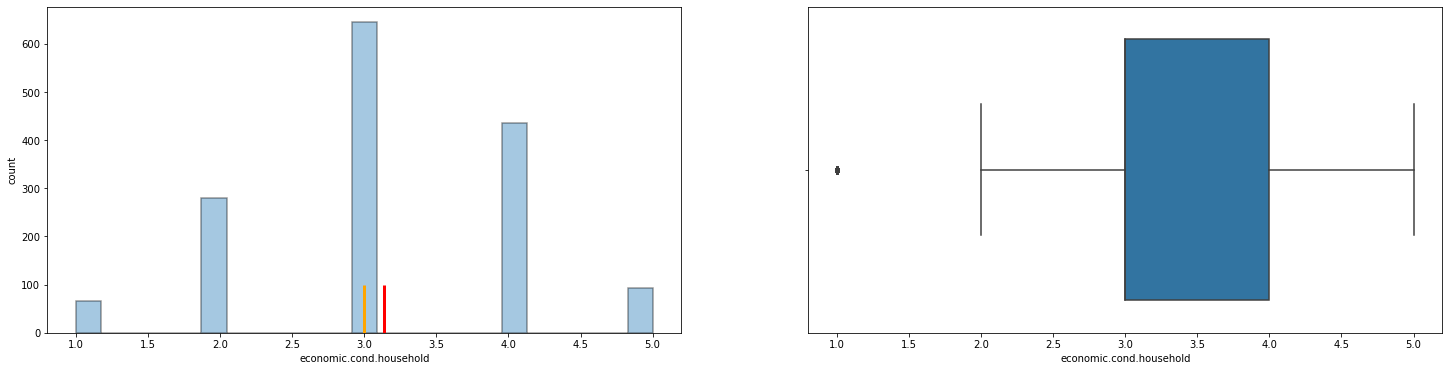

Blair
Skew: -0.54


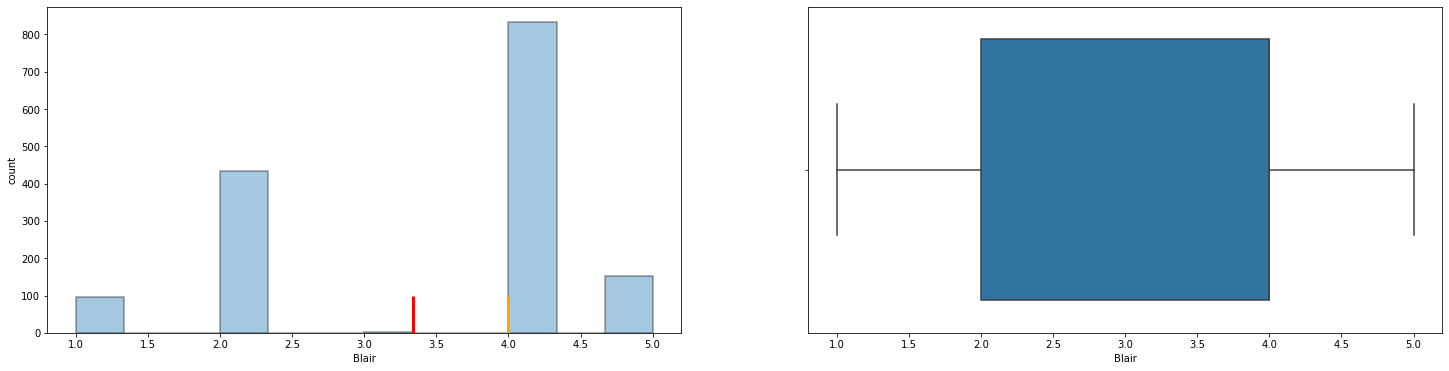

Hague
Skew: 0.15


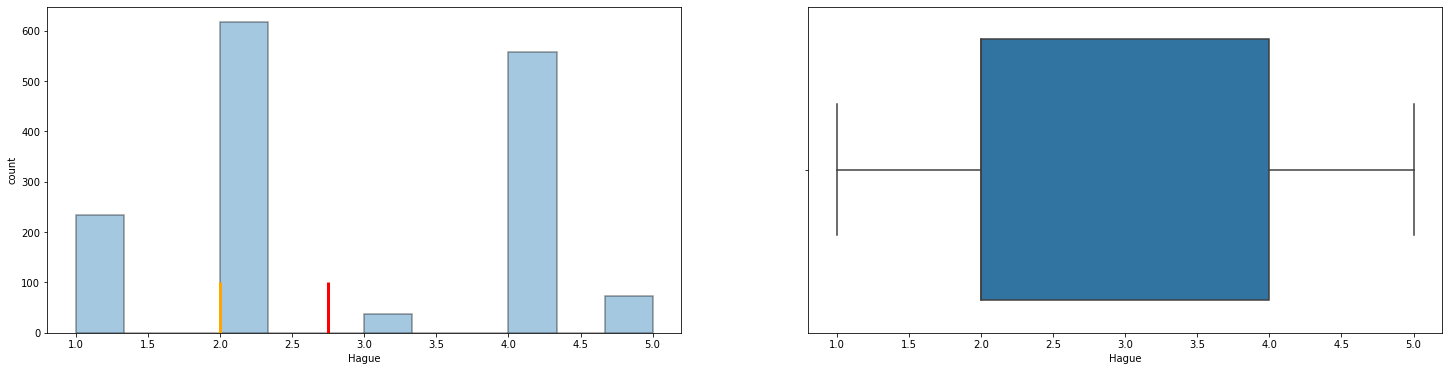

Europe
Skew: -0.14


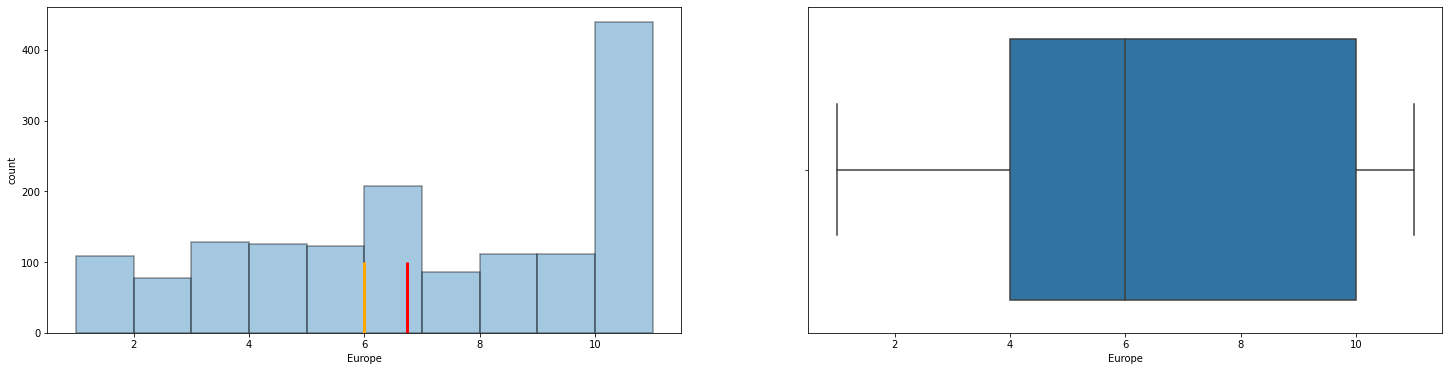

political.knowledge
Skew: -0.42


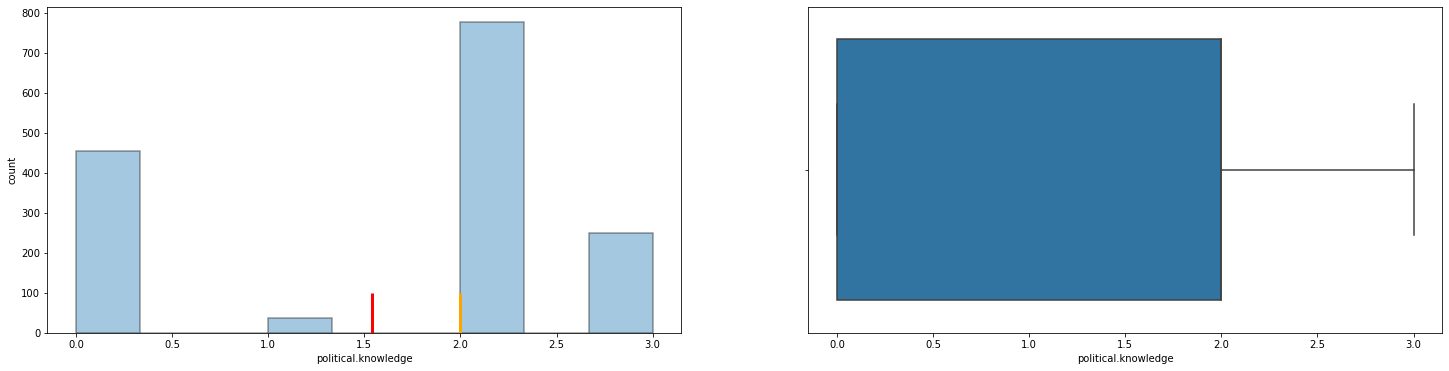

In [19]:
cont = df.select_dtypes(include = ['int64'])
cols = list(cont.columns)
for col in cols:
    print(col)
    print('Skew:', np.round(df[col].skew(),2)) 
    plt.figure(figsize=(25,6))
    plt.subplot(1,2,1)
    sns.distplot(df[col],norm_hist=False,kde=False,hist_kws=dict(edgecolor='black',linewidth=1.5))
    plt.vlines(df[col].mean(),ymin=0, ymax=100, color = 'red', linewidth=3)
    plt.vlines(df[col].median(),ymin=0, ymax=100, color = 'orange', linewidth=3)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(df[col])
    plt.show()

From above it can be seen clearly that "Blair" and "political knowledge" variables are slightly left skewed. Whereas, the other variables are somewhat normally distributed. Also, both variables for "economic.cond.national" and "economic.cond.household" containing outliers. However, even though there is a presence of outliers as per dataset, they appear for ordinal variables and not for continuous variables and hence, we will not treat the outliers for this case as of now. 

## Bivariate Analysis

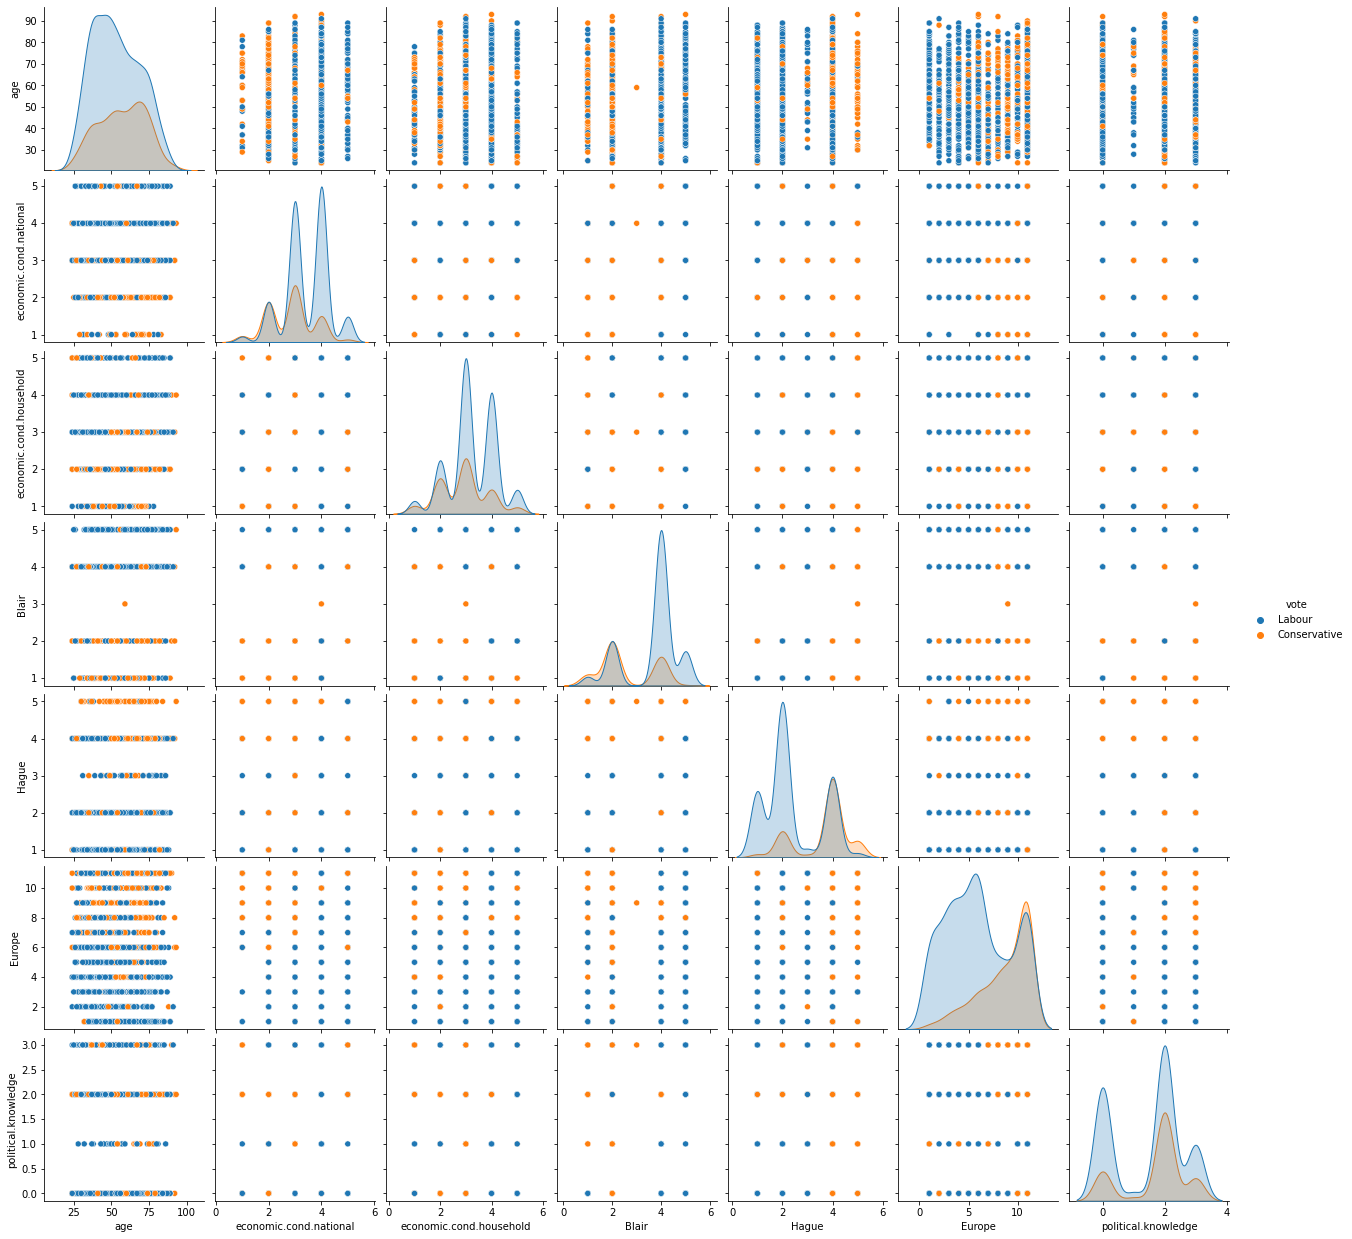

In [20]:
sns.pairplot(df, hue='vote', diag_kind='kde')

For the diagonals above we can observe that the classes even though are slightly overlapping, they are still well seperated and thus the dataset may prove to have enough good predictors for the model and an overall high f score as well. Let us further check on the correlation of the independent variables as from the above figure it seems the independent variables do not have strong correlations with each other. 

## Correlation 

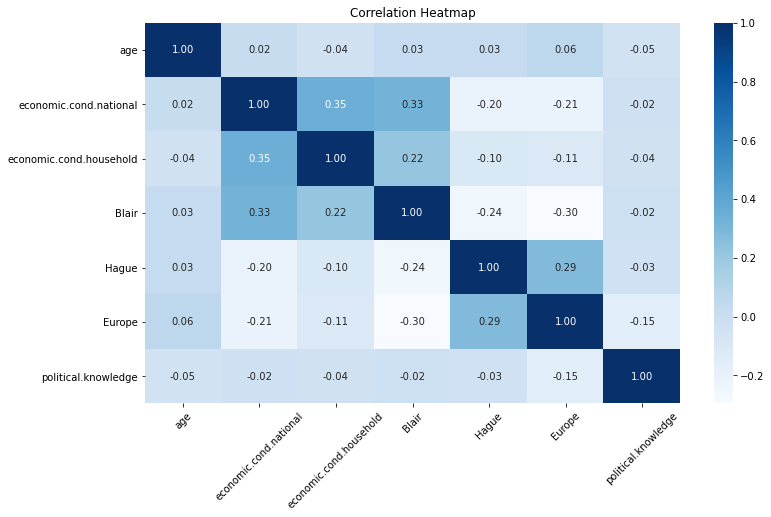

In [21]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Blues')
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.show()

As stated earlier, we do not see any strong correlation among the independent variables which is a good sign for regression. 

# 1.3 Encode the data (having string values) for Modelling. Is Scaling necessary here or not? Data Split: Split the data into train and test (70:30).

## One Hote Encoding Categorical Variables

In [22]:
cat = ['vote', 'gender']

In [23]:
df_new =pd.get_dummies(df, columns=cat,drop_first=True)

In [24]:
df_new.head()

,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,vote_Labour,gender_male
0,43,3,3,4,1,2,2,1,0
1,36,4,4,4,4,5,2,1,1
2,35,4,4,5,2,3,2,1,1
3,24,4,2,2,1,4,0,1,0
4,41,2,2,1,1,6,2,1,1


In [25]:
df_new= df_new.rename(columns={'vote_Labour':'Labour=1_Conservative=0' ,'gender_male':'Male=1_Female=0'},inplace= False)

In [26]:
df_new.head()

,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,Labour=1_Conservative=0,Male=1_Female=0
0,43,3,3,4,1,2,2,1,0
1,36,4,4,4,4,5,2,1,1
2,35,4,4,5,2,3,2,1,1
3,24,4,2,2,1,4,0,1,0
4,41,2,2,1,1,6,2,1,1


In [27]:
df_new.shape

(1517, 9)

Using one hot encoding we have replaced the categorical variables of "gender" and "vote" into continuous variables "Male=1_Female=0" and "Labour=1_Conservative=0" which will enable us to perform regression on the dataset. The contents of the dataset remain same of 1517 rows and 9 columns.

## Train-Test Split (70:30)

In [28]:
# Copy all the predictor variables into X dataframe
X = df_new.drop('Labour=1_Conservative=0', axis=1)

# Copy target into the Y dataframe. 
Y = df_new['Labour=1_Conservative=0']

In [29]:
X.head()

,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,Male=1_Female=0
0,43,3,3,4,1,2,2,0
1,36,4,4,4,4,5,2,1
2,35,4,4,5,2,3,2,1
3,24,4,2,2,1,4,0,0
4,41,2,2,1,1,6,2,1


In [30]:
# Split X and Y into training and test set in 70:30 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30 , random_state=1)

In [27]:
Y_train.value_counts(normalize=True) 

1    0.71065
0    0.28935
Name: Labour=1_Conservative=0, dtype: float64

In [28]:
Y_test.value_counts(normalize=True) 

1    0.664474
0    0.335526
Name: Labour=1_Conservative=0, dtype: float64

The proportion of classes in both train and test datasets have a good balance to perform the analysis. Hence, we do not need to use class imbalance reducing techniques such as SMOTE here. As a rule of thumb, class imbalance is present where the minority class is lower than 10% of the dataset and in this case, all classes clearly make more than 10% of the dataset.

# 1.4 Apply Logistic Regression and LDA (linear discriminant analysis)

In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:
# Fit the Logistic Regression model
model = LogisticRegression(solver='newton-cg',max_iter=10000,penalty='none',verbose=True,n_jobs=2)
model.fit(X_train, Y_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   31.6s finished


LogisticRegression(max_iter=10000, n_jobs=2, penalty='none', solver='newton-cg',
                   verbose=True)

## Predicting on Training and Test dataset

In [59]:
ytrain_predict = model.predict(X_train)
ytest_predict = model.predict(X_test)

## Getting the Predicted Classes and Probs

In [60]:
ytest_predict_prob=model.predict_proba(X_test)
pd.DataFrame(ytest_predict_prob).head()

,0,1
0,0.424284,0.575716
1,0.148426,0.851574
2,0.007187,0.992813
3,0.836350,0.163650
4,0.068407,0.931593


## Model Evaluation (LR)

In [61]:
# Accuracy - Training Data
model.score(X_train, Y_train)

0.8312912346842601

In [62]:
# Accuracy - Test Data
model.score(X_test, Y_test)

0.8355263157894737

Training score is 0.8312912346842601 (83.13%) whereas Testing score is 0.8355263157894737 (83.55%)

## AUC and ROC for the training data (LR)

AUC: 0.890


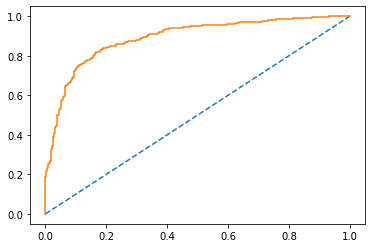

In [63]:
# predict probabilities
probs = model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);

## AUC and ROC for the test data (LR)

AUC: 0.890


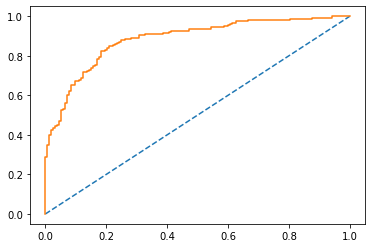

In [64]:
# predict probabilities
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr);

AUC and ROC scores are same for training dataset and testing dataset at 89%

## Confusion Matrix for the training data (LR)

In [65]:
confusion_matrix(Y_train, ytrain_predict)

array([[196, 111],
       [ 68, 686]], dtype=int64)

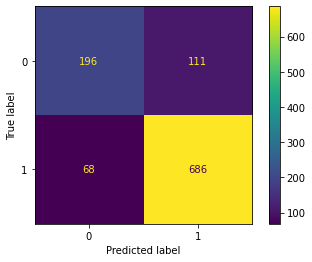

In [66]:
plot_confusion_matrix(model,X_train,Y_train);

In [67]:
print(classification_report(Y_train, ytrain_predict))

              precision    recall  f1-score   support

           0       0.74      0.64      0.69       307
           1       0.86      0.91      0.88       754

    accuracy                           0.83      1061
   macro avg       0.80      0.77      0.79      1061
weighted avg       0.83      0.83      0.83      1061



## Confusion Matrix for the testing data (LR)

In [68]:
confusion_matrix(Y_test, ytest_predict)

array([[113,  40],
       [ 35, 268]], dtype=int64)

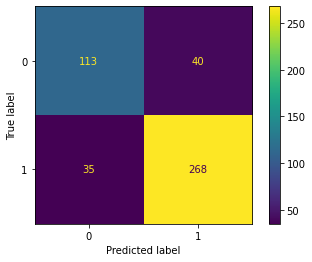

In [69]:
plot_confusion_matrix(model,X_test,Y_test);

In [70]:
print(classification_report(Y_test, ytest_predict))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75       153
           1       0.87      0.88      0.88       303

    accuracy                           0.84       456
   macro avg       0.82      0.81      0.81       456
weighted avg       0.83      0.84      0.83       456



In logistic Regression Model, the Confusion Matrix f1 scores is same for training dataset and testing dataset for target variable at 88%. Whereas, precision is almost similar with 86% for training and 87% for testing dataset while, recall can be seen as 91% for training and 88% for testing dataset for target variable. All of which are good scores and seems that our LR model has performed good. 

## LDA Model

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [72]:
#Build LDA Model
clf = LinearDiscriminantAnalysis()
model=clf.fit(X_train,Y_train)

In [73]:
# Training Data Class Prediction with a cut-off value of 0.5
pred_class_train = model.predict(X_train)

# Test Data Class Prediction with a cut-off value of 0.5
pred_class_test = model.predict(X_test)

In [74]:
# Accuracy - Training Data
model.score(X_train, Y_train)

0.8341187558906692

In [75]:
# Accuracy - Test Data
model.score(X_test, Y_test)

0.8333333333333334

Training score is 0.8341187558906692 (83.41%) whereas Testing score is 0.8333333333333334 (83.33%)

## Training Data and Test Data Confusion Matrix Comparison (LDA)

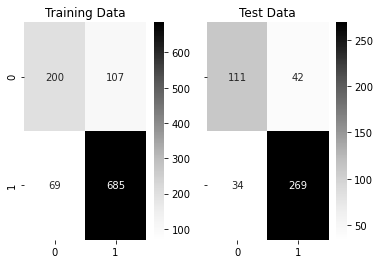

In [76]:
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(Y_train,pred_class_train)),annot=True,fmt='.5g',cmap='Greys, ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(Y_test,pred_class_test)),annot=True,fmt='.5g',cmap='Greys',ax=a[0][1]);
a[0][1].set_title('Test Data');


## Training Data and Test Data Classification Report Comparison (LDA)

In [77]:
print('Classification Report of the training data as per LDA:\n\n',metrics.classification_report(Y_train,pred_class_train),'\n')
print('Classification Report of the test data as per LDA:\n\n',metrics.classification_report(Y_test,pred_class_test),'\n')

Classification Report of the training data as per LDA:

               precision    recall  f1-score   support

           0       0.74      0.65      0.69       307
           1       0.86      0.91      0.89       754

    accuracy                           0.83      1061
   macro avg       0.80      0.78      0.79      1061
weighted avg       0.83      0.83      0.83      1061
 

Classification Report of the test data as per LDA:

               precision    recall  f1-score   support

           0       0.77      0.73      0.74       153
           1       0.86      0.89      0.88       303

    accuracy                           0.83       456
   macro avg       0.82      0.81      0.81       456
weighted avg       0.83      0.83      0.83       456
 



In LDA Model, the Confusion Matrix f1 scores are almost similar for training dataset (89%) and testing dataset (88%) for target variable. Whereas, precision is same at 86% and recall can be seen as 91% for training and 89% for testing dataset for target variable. All of which are good scores and seems that our LDA model also has performed quite good. 

## AUC and ROC for the training and test data (LDA)

In [78]:
# Training Data Probability Prediction
pred_prob_train = model.predict_proba(X_train)

# Test Data Probability Prediction
pred_prob_test = model.predict_proba(X_test)

AUC for the Training Data: 0.889
AUC for the Test Data: 0.888


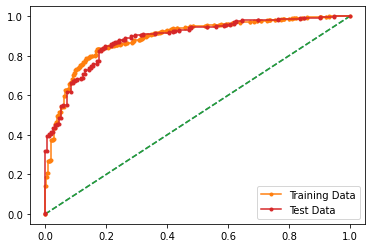

In [79]:
# AUC and ROC for the training data

# calculate AUC
auc = metrics.roc_auc_score(Y_train,pred_prob_train[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = metrics.roc_curve(Y_train,pred_prob_train[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')


# AUC and ROC for the test data

# calculate AUC
auc = metrics.roc_auc_score(Y_test,pred_prob_test[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = metrics.roc_curve(Y_test,pred_prob_test[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.show()

In LDA, the AUC and ROC scores are same for training dataset and testing dataset at 89%

# 1.5 Apply KNN Model and Naïve Bayes Model. Interpret the results.

# Naive Bayes Model (Gaussian)

In [29]:
from sklearn.naive_bayes import GaussianNB

NB_model = GaussianNB()

NB_model.fit(X_train, Y_train)

GaussianNB()

## Performance of our model with train and test data (NB)

In [62]:
NB_train_predict = NB_model.predict(X_train)
NB_test_predict = NB_model.predict(X_test)
print("Model Accuracy for training data in NB: {0:.2f}".format(metrics.accuracy_score(Y_train, NB_train_predict)))
print("Model Accuracy for test data in NB: {0:.2f}".format(metrics.accuracy_score(Y_test, NB_test_predict)))
print()

Model Accuracy for training data in NB: 0.84
Model Accuracy for test data in NB: 0.82



## Training Data and Test Data Confusion Matrix Comparison (NB)

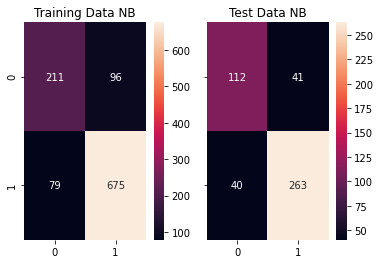

In [63]:
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(Y_train,NB_train_predict)),annot=True,fmt='.5g',ax=a[0][0]);
a[0][0].set_title('Training Data NB')

plot_1 = sns.heatmap((metrics.confusion_matrix(Y_test,NB_test_predict)),annot=True,fmt='.5g',ax=a[0][1]);
a[0][1].set_title('Test Data NB');

## Training Data and Test Data Classification Report Comparison (NB)

In [35]:
print('Classification Report of the training data as per NB:\n\n',metrics.classification_report(Y_train,NB_train_predict),'\n')
print('Classification Report of the test data as per NB:\n\n',metrics.classification_report(Y_test,NB_test_predict),'\n')

Classification Report of the training data as per NB:

               precision    recall  f1-score   support

           0       0.73      0.69      0.71       307
           1       0.88      0.90      0.89       754

    accuracy                           0.84      1061
   macro avg       0.80      0.79      0.80      1061
weighted avg       0.83      0.84      0.83      1061
 

Classification Report of the test data as per NB:

               precision    recall  f1-score   support

           0       0.74      0.73      0.73       153
           1       0.87      0.87      0.87       303

    accuracy                           0.82       456
   macro avg       0.80      0.80      0.80       456
weighted avg       0.82      0.82      0.82       456
 



In NB Model, the f1 scores are almost similar for training dataset (89%) and testing dataset (87%) for target variable. Whereas, precision is at 88% for training dataset and 87% for test dataset. The recall can be seen as 90% for training and 87% for testing dataset for target variable. All of which are good scores and seems that our NB model also has performed quite good. 

## AUC and ROC for the training and test data (NB)

AUC for the Training Data in NB: 0.89 
AUC for the Test Data in NB: 0.88 


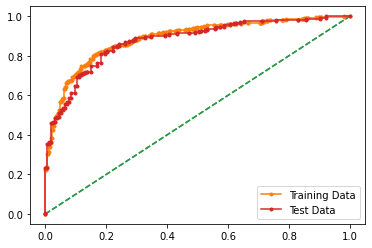

In [64]:
# AUC and ROC for the training data

probs_train=NB_model.predict_proba(X_train)
probs_train=probs_train[:, 1]

auc=roc_auc_score(Y_train,probs_train)
print("AUC for the Training Data in NB: %.2f " % auc)
fpr ,tpr, thresholds= roc_curve(Y_train,probs_train)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

probs_test=NB_model.predict_proba(X_test)
probs_test=probs_test[:,1]

auc=roc_auc_score(Y_test,probs_test)
print("AUC for the Test Data in NB: %.2f " % auc)
fpr,tpr,threshold=roc_curve(Y_test,probs_test)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr, tpr, marker='.',label = 'Test Data')

# show the plot
plt.legend(loc='best')
plt.show()

In NB, the AUC and ROC scores almost the same for training dataset 89% and testing dataset at 88%

##### We will now scale the dataset when building the KNN model as scaling is necessary here because "age" variable is continuous in nature whereas, the other independent numerical variables are in ordinal and binary form. Also, KNN model needs to be scaled as it is distance based and for distance based models, scaling becomes a mandate.

##### We did not scale the dataset while building the previous models as for Logistic Regression and LDA we do not scale the categorical variables and NaiveBayes is not affected by feature scaling as it is not a distance based model. We will also use the unscaled dataset for Bagging ( Random Forest) and Boosting as well. 

##### We will use Zscore standardization as it lowers the variation in the dataset bringing the distribution of the features in the dataset to a mean of 0 and standard deviation of 1. Also, we do have a few outliers in the dataset as well in the variables of “economic.cond.national” and “economic.cond.hosehold” and zscore standardization is useful in handling outliers.

# KNN Model

In [39]:
from scipy.stats import zscore #to scale the dataset

In [41]:
x= df_new.drop("Labour=1_Conservative=0",axis=1)

y= df_new["Labour=1_Conservative=0"]

In [42]:
x.head()

,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,Male=1_Female=0
0,43,3,3,4,1,2,2,0
1,36,4,4,4,4,5,2,1
2,35,4,4,5,2,3,2,1
3,24,4,2,2,1,4,0,0
4,41,2,2,1,1,6,2,1


In [55]:
x = x.apply(zscore)
x.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1517.0,3.791005e-17,1.00033,-1.926617,-0.843577,-0.079079,0.812836,2.469250
economic.cond.national,1517.0,-3.641707e-16,1.00033,-2.547041,-0.278185,-0.278185,0.856242,1.990670
economic.cond.household,1517.0,-2.069318e-16,1.00033,-2.296796,-0.148020,-0.148020,0.926367,2.000755
Blair,1517.0,-1.642281e-16,1.00033,-1.988727,-1.137217,0.565802,0.565802,1.417312
Hague,1517.0,-2.400482e-17,1.00033,-1.419969,-0.608329,-0.608329,1.014951,1.826592
Europe,1517.0,4.069110e-17,1.00033,-1.740556,-0.830902,-0.224465,0.988407,1.291625
political.knowledge,1517.0,-7.617140e-16,1.00033,-1.421084,-1.421084,0.423832,0.423832,1.346290
Male=1_Female=0,1517.0,2.648581e-16,1.00033,-0.936736,-0.936736,-0.936736,1.067536,1.067536


In [49]:
# Split x and y into training and test set in 70:30 ratio
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30 , random_state=1)

In [50]:
y_train.value_counts(normalize=True) 

1    0.71065
0    0.28935
Name: Labour=1_Conservative=0, dtype: float64

In [51]:
y_test.value_counts(normalize=True) 

1    0.664474
0    0.335526
Name: Labour=1_Conservative=0, dtype: float64

In [60]:
from sklearn.neighbors import KNeighborsClassifier

NNH=KNeighborsClassifier(weights='distance')

# Call Nearest Neighbour algorithm
NNH.fit(x_train,y_train)

KNeighborsClassifier(weights='distance')

## Evaluate Performance of KNN Model

In [69]:
NNH_train_predict = NNH.predict(x_train)
NNH_test_predict = NNH.predict(x_test)
print("Model Accuracy for training data in KNN: {0:.2f}".format(metrics.accuracy_score(y_train, NNH_train_predict)))
print("Model Accuracy for test data in KNN: {0:.2f}".format(metrics.accuracy_score(y_test, NNH_test_predict)))
print()

Model Accuracy for training data in KNN: 1.00
Model Accuracy for test data in KNN: 0.82



It can be observed that the KNN Model has over-fitted in the training dataset but not in the test dataset

## Training Data and Test Data Confusion Matrix Comparison (KNN)

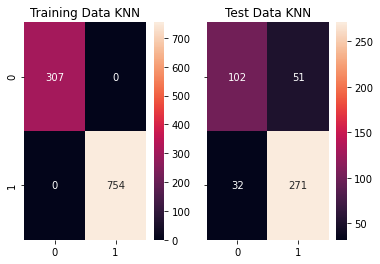

In [70]:
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train,NNH_train_predict)),annot=True,fmt='.5g',ax=a[0][0]);
a[0][0].set_title('Training Data KNN')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test,NNH_test_predict)),annot=True,fmt='.5g',ax=a[0][1]);
a[0][1].set_title('Test Data KNN');

## Training Data and Test Data Classification Report Comparison (KNN)

In [71]:
print('Classification Report of the training data as per KNN:\n\n',metrics.classification_report(y_train,NNH_train_predict),'\n')
print('Classification Report of the test data as per KNN:\n\n',metrics.classification_report(y_test,NNH_test_predict),'\n')

Classification Report of the training data as per KNN:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       307
           1       1.00      1.00      1.00       754

    accuracy                           1.00      1061
   macro avg       1.00      1.00      1.00      1061
weighted avg       1.00      1.00      1.00      1061
 

Classification Report of the test data as per KNN:

               precision    recall  f1-score   support

           0       0.76      0.67      0.71       153
           1       0.84      0.89      0.87       303

    accuracy                           0.82       456
   macro avg       0.80      0.78      0.79       456
weighted avg       0.81      0.82      0.81       456
 



In KNN Model, it is clear that all the scores for the train dataset set is 100% indicating that it is a complex model and as a result we can see an over-fitting issue. However, f1 scores for testing dataset is 87%, precision is at 84% and recall is 89% for target variable. Thus, indicating that though the model performed poorly compared to the training dataset it is still a good model.

## AUC and ROC for the training and test data (KNN)

AUC for the Training Data in KNN: 1.00 
AUC for the Test Data in NB: 0.87 


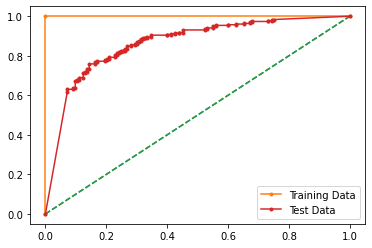

In [72]:
# AUC and ROC for the training data

probs_train=NNH.predict_proba(x_train)
probs_train=probs_train[:, 1]

auc=roc_auc_score(y_train,probs_train)
print("AUC for the Training Data in KNN: %.2f " % auc)
fpr ,tpr, thresholds= roc_curve(y_train,probs_train)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

probs_test=NNH.predict_proba(x_test)
probs_test=probs_test[:,1]

auc=roc_auc_score(y_test,probs_test)
print("AUC for the Test Data in KNN: %.2f " % auc)
fpr,tpr,threshold=roc_curve(y_test,probs_test)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr, tpr, marker='.',label = 'Test Data')

# show the plot
plt.legend(loc='best')
plt.show()

### Choosing the right K- Value
Usually we chose an odd number. A small K captures too much training noise and does not do well in the test data. Also, a very large K does so much smoothening, that it does not manage to capture information in a trained data sufficiently - and hence does not do well in test data.

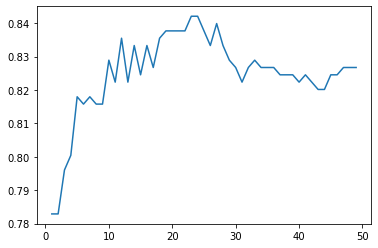

In [77]:
scores = []
for k in range (1,50):
    NNH = KNeighborsClassifier(n_neighbors = k , weights = 'distance')
    NNH.fit(x_train, y_train)
    scores.append(NNH.score(x_test, y_test))
plt.plot(range(1,50),scores)

From above chart we can observe that the model provides best result of 0.84 (refer Y-axis) when k is in the range of 20 and 30.
 
Most experts suggest that k=square root of train dataset is usually the best k-value. However, we will explore this theory further and check if it is also the case for our dataset here. 

The square root of the train dataset of 1061 features (please refer any of the previous classification report for the features for train dataset for this dataset) ie; 32.57 and if it as well can be the best k-value for this particular case study.

In [119]:
NNH_new = KNeighborsClassifier(n_neighbors = 27 , weights = 'distance')

# Call Nearest Neighbour algorithm
NNH_new.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=27, weights='distance')

## Evaluate Performance of KNN_New Model

In [120]:
NNH_new_train_predict = NNH_new.predict(x_train)
NNH_new_test_predict = NNH_new.predict(x_test)
print("Model Accuracy for training data in KNN: {0:.4f}".format(metrics.accuracy_score(y_train, NNH_new_train_predict)))
print("Model Accuracy for test data in KNN: {0:.4f}".format(metrics.accuracy_score(y_test, NNH_new_test_predict)))
print()

Model Accuracy for training data in KNN: 1.0000
Model Accuracy for test data in KNN: 0.8399



It can be observed that the KNN Model has over-fitted in the training dataset but not in the test dataset

## Training Data and Test Data Confusion Matrix Comparison (KNN_New)

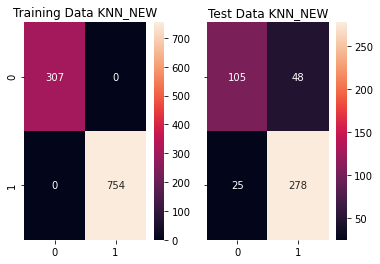

In [121]:
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train,NNH_new_train_predict)),annot=True,fmt='.5g',ax=a[0][0]);
a[0][0].set_title('Training Data KNN_NEW')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test,NNH_new_test_predict)),annot=True,fmt='.5g',ax=a[0][1]);
a[0][1].set_title('Test Data KNN_NEW');

## Training Data and Test Data Classification Report Comparison (KNN_New)

In [123]:
print('Classification Report of the training data as per KNN_NEW:\n\n',metrics.classification_report(y_train,NNH_new_train_predict),'\n')
print('Classification Report of the test data as per KNN_NEW:\n\n',metrics.classification_report(y_test,NNH_new_test_predict),'\n')

Classification Report of the training data as per KNN_NEW:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       307
           1       1.00      1.00      1.00       754

    accuracy                           1.00      1061
   macro avg       1.00      1.00      1.00      1061
weighted avg       1.00      1.00      1.00      1061
 

Classification Report of the test data as per KNN_NEW:

               precision    recall  f1-score   support

           0       0.81      0.69      0.74       153
           1       0.85      0.92      0.88       303

    accuracy                           0.84       456
   macro avg       0.83      0.80      0.81       456
weighted avg       0.84      0.84      0.84       456
 



In KNN_new Model, the scores have slighly increased using k = 27 as the f1 scores for testing dataset is seen 88%, precision is at 85% and recall is 92% for target variable.

## AUC and ROC for the training and test data (KNN_New)

AUC for the Training Data in KNN_new: 1.00 
AUC for the Test Data in KNN_new: 0.88 


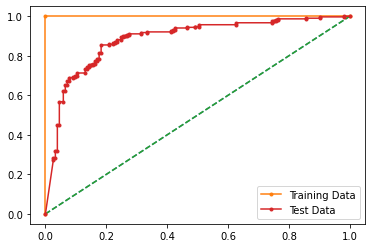

In [124]:
# AUC and ROC for the training data

NNH_new_probs_train=NNH_new.predict_proba(x_train)
NNH_new_probs_train=NNH_new_probs_train[:, 1]

auc=roc_auc_score(y_train,NNH_new_probs_train)
print("AUC for the Training Data in KNN_new: %.2f " % auc)
fpr ,tpr, thresholds= roc_curve(y_train,probs_train)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

NNH_new_probs_test=NNH_new.predict_proba(x_test)
NNH_new_probs_test=NNH_new_probs_test[:,1]

auc=roc_auc_score(y_test,NNH_new_probs_test)
print("AUC for the Test Data in KNN_new: %.2f " % auc)
fpr,tpr,threshold=roc_curve(y_test,NNH_new_probs_test)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr, tpr, marker='.',label = 'Test Data')

# show the plot
plt.legend(loc='best')
plt.show()

# 1.6 Model Tuning, Bagging (Random Forest should be applied for Bagging), and Boosting. 

In [4]:
from sklearn.tree import DecisionTreeClassifier
from os import system
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Building a Random Forest Classifier

In [31]:
param_grid = { 
    'n_estimators': [100],
    'max_features': ['auto', 'sqrt']
}

rfcl = RandomForestClassifier(random_state=1)
grid_search = GridSearchCV(estimator = rfcl, param_grid = param_grid, cv = 5)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'n_estimators': [100]})

In [32]:
grid_search.best_params_

{'max_features': 'auto', 'n_estimators': 100}

In [33]:
best_grid = grid_search.best_estimator_

In [34]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [35]:
from sklearn.metrics import confusion_matrix,classification_report

## Training Data and Test Data Confusion Matrix Comparison (RF)

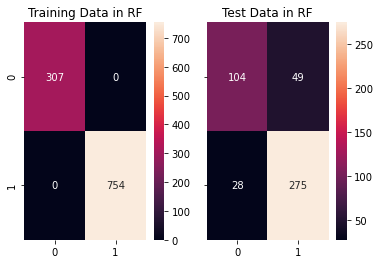

In [36]:
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(Y_train,ytrain_predict)),annot=True,fmt='.5g',ax=a[0][0]);
a[0][0].set_title('Training Data in RF')

plot_1 = sns.heatmap((metrics.confusion_matrix(Y_test,ytest_predict)),annot=True,fmt='.5g',ax=a[0][1]);
a[0][1].set_title('Test Data in RF');

## Training Data and Test Data Classification Report Comparison (RF)

In [37]:
print('Classification Report of the training data as per RF:\n\n',metrics.classification_report(Y_train,ytrain_predict),'\n')
print('Classification Report of the test data as per RF:\n\n',metrics.classification_report(Y_test,ytest_predict),'\n')

Classification Report of the training data as per RF:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       307
           1       1.00      1.00      1.00       754

    accuracy                           1.00      1061
   macro avg       1.00      1.00      1.00      1061
weighted avg       1.00      1.00      1.00      1061
 

Classification Report of the test data as per RF:

               precision    recall  f1-score   support

           0       0.79      0.68      0.73       153
           1       0.85      0.91      0.88       303

    accuracy                           0.83       456
   macro avg       0.82      0.79      0.80       456
weighted avg       0.83      0.83      0.83       456
 



In RF Model, the f1 scores for testing dataset is seen 88%, precision is at 85% and recall is 91% for target variable.

## AUC and ROC for the training and test data (RF)

AUC for the Training Data in RF: 1.00 
AUC for the Test Data in RF: 0.90 


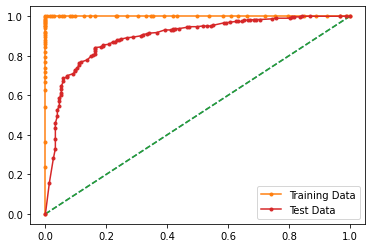

In [38]:
# AUC and ROC for the training data

rf_probs_train = best_grid.predict_proba(X_train)
rf_probs_train = rf_probs_train [:, 1]

auc=roc_auc_score(Y_train,rf_probs_train)
print("AUC for the Training Data in RF: %.2f " % auc)
fpr ,tpr, thresholds= roc_curve(Y_train,rf_probs_train)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

rf_probs_test = best_grid.predict_proba(X_test)
rf_probs_test = rf_probs_test[:,1]

auc=roc_auc_score(Y_test,rf_probs_test)
print("AUC for the Test Data in RF: %.2f " % auc)
fpr,tpr,threshold=roc_curve(Y_test,rf_probs_test)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr, tpr, marker='.',label = 'Test Data')

# show the plot
plt.legend(loc='best')
plt.show()

## Bagging (Random Forest)

In [39]:
from sklearn.ensemble import BaggingClassifier

In [40]:
bgcl = BaggingClassifier(base_estimator=rfcl, n_estimators=100,random_state=1)
bgcl = bgcl.fit(X_train, Y_train)

In [41]:
bgcl_train_predict = bgcl.predict(X_train)
bgcl_test_predict = bgcl.predict(X_test)

## Training Data and Test Data Confusion Matrix Comparison (Bagging)

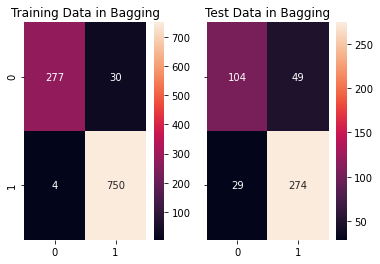

In [42]:
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(Y_train,bgcl_train_predict)),annot=True,fmt='.5g',ax=a[0][0]);
a[0][0].set_title('Training Data in Bagging')

plot_1 = sns.heatmap((metrics.confusion_matrix(Y_test,bgcl_test_predict)),annot=True,fmt='.5g',ax=a[0][1]);
a[0][1].set_title('Test Data in Bagging');

## Training Data and Test Data Classification Report Comparison (Bagging)

In [43]:
print('Classification Report of the training data as per Bagging:\n\n',metrics.classification_report(Y_train,bgcl_train_predict),'\n')
print('Classification Report of the test data as per Bagging:\n\n',metrics.classification_report(Y_test,bgcl_test_predict),'\n')

Classification Report of the training data as per Bagging:

               precision    recall  f1-score   support

           0       0.99      0.90      0.94       307
           1       0.96      0.99      0.98       754

    accuracy                           0.97      1061
   macro avg       0.97      0.95      0.96      1061
weighted avg       0.97      0.97      0.97      1061
 

Classification Report of the test data as per Bagging:

               precision    recall  f1-score   support

           0       0.78      0.68      0.73       153
           1       0.85      0.90      0.88       303

    accuracy                           0.83       456
   macro avg       0.82      0.79      0.80       456
weighted avg       0.83      0.83      0.83       456
 



In Bagging Model, the scores for training dataset has reduced from a 100% for each parameter as seen under Random Forest to slightly lesser dimensions with f1 at 98%, precision at 96% and recall at 99% and for testing dataset it can be seen that the f1 score is 88%, precision is at 85% and recall is 90% for target variable.

## AUC and ROC for the training and test data (Bagging)

AUC for the Training Data in Bagging: 1.00 
AUC for the Test Data in Bagging: 0.90 


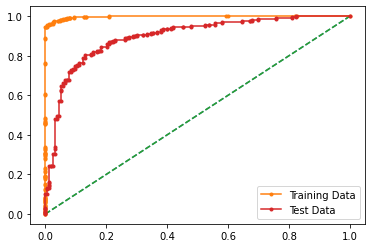

In [44]:
# AUC and ROC for the training data

bgcl_probs_train = bgcl.predict_proba(X_train)
bgcl_probs_train = bgcl_probs_train [:, 1]

auc=roc_auc_score(Y_train,bgcl_probs_train)
print("AUC for the Training Data in Bagging: %.2f " % auc)
fpr ,tpr, thresholds= roc_curve(Y_train,bgcl_probs_train)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

bgcl_probs_test = bgcl.predict_proba(X_test)
bgcl_probs_test = bgcl_probs_test[:,1]

auc=roc_auc_score(Y_test,bgcl_probs_test)
print("AUC for the Test Data in Bagging: %.2f " % auc)
fpr,tpr,threshold=roc_curve(Y_test,bgcl_probs_test)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr, tpr, marker='.',label = 'Test Data')

# show the plot
plt.legend(loc='best')
plt.show()

## Boosting (AdaBoost)

In [45]:
from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier(random_state=1)
abcl = abcl.fit(X_train, Y_train)

In [46]:
abcl_train_predict = abcl.predict(X_train)
abcl_test_predict = abcl.predict(X_test)

## Training Data and Test Data Confusion Matrix Comparison (AdaBoost)

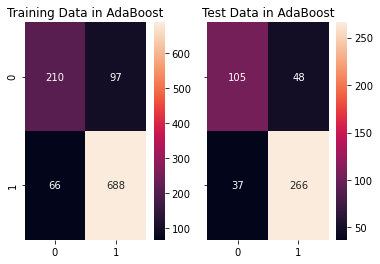

In [47]:
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(Y_train,abcl_train_predict)),annot=True,fmt='.5g',ax=a[0][0]);
a[0][0].set_title('Training Data in AdaBoost')

plot_1 = sns.heatmap((metrics.confusion_matrix(Y_test,abcl_test_predict)),annot=True,fmt='.5g',ax=a[0][1]);
a[0][1].set_title('Test Data in AdaBoost');

## Training Data and Test Data Classification Report Comparison (AdaBoost)

In [48]:
print('Classification Report of the training data as per AdaBoost:\n\n',metrics.classification_report(Y_train,abcl_train_predict),'\n')
print('Classification Report of the test data as per AdaBoost:\n\n',metrics.classification_report(Y_test,abcl_test_predict),'\n')

Classification Report of the training data as per AdaBoost:

               precision    recall  f1-score   support

           0       0.76      0.68      0.72       307
           1       0.88      0.91      0.89       754

    accuracy                           0.85      1061
   macro avg       0.82      0.80      0.81      1061
weighted avg       0.84      0.85      0.84      1061
 

Classification Report of the test data as per AdaBoost:

               precision    recall  f1-score   support

           0       0.74      0.69      0.71       153
           1       0.85      0.88      0.86       303

    accuracy                           0.81       456
   macro avg       0.79      0.78      0.79       456
weighted avg       0.81      0.81      0.81       456
 



In ADA Model, the scores for training dataset has the f1 scores at 89%, precision at 88% and recall at 91% and for testing dataset it is seen that the f1 score is 86%, precision is at 85% and recall is 88% for target variable.

## AUC and ROC for the training and test data (AdaBoost)

AUC for the Training Data in AdaBoost: 0.91 
AUC for the Test Data in AdaBoost: 0.88 


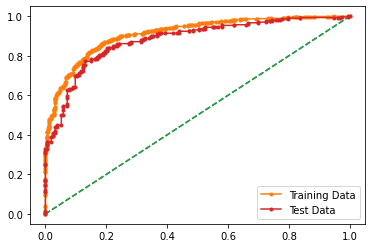

In [49]:
# AUC and ROC for the training data

abcl_probs_train = abcl.predict_proba(X_train)
abcl_probs_train = abcl_probs_train [:, 1]

auc=roc_auc_score(Y_train,abcl_probs_train)
print("AUC for the Training Data in AdaBoost: %.2f " % auc)
fpr ,tpr, thresholds= roc_curve(Y_train,abcl_probs_train)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

abcl_probs_test = abcl.predict_proba(X_test)
abcl_probs_test = abcl_probs_test[:,1]

auc=roc_auc_score(Y_test,abcl_probs_test)
print("AUC for the Test Data in AdaBoost: %.2f " % auc)
fpr,tpr,threshold=roc_curve(Y_test,abcl_probs_test)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr, tpr, marker='.',label = 'Test Data')

# show the plot
plt.legend(loc='best')
plt.show()

## Boosting (GradientBoost)

In [50]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(random_state=1)
gbcl = gbcl.fit(X_train, Y_train)

In [51]:
gbcl_train_predict = gbcl.predict(X_train)
gbcl_test_predict = gbcl.predict(X_test)

## Training Data and Test Data Confusion Matrix Comparison (GradientBoost)

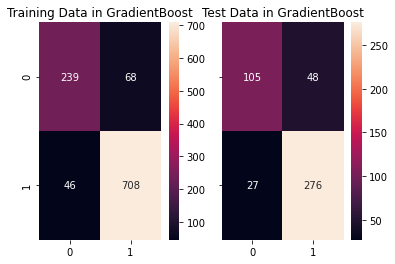

In [52]:
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(Y_train,gbcl_train_predict)),annot=True,fmt='.5g',ax=a[0][0]);
a[0][0].set_title('Training Data in GradientBoost')

plot_1 = sns.heatmap((metrics.confusion_matrix(Y_test,gbcl_test_predict)),annot=True,fmt='.5g',ax=a[0][1]);
a[0][1].set_title('Test Data in GradientBoost');

## Training Data and Test Data Classification Report Comparison (GradientBoost)

In [53]:
print('Classification Report of the training data as per GradientBoost:\n\n',metrics.classification_report(Y_train,gbcl_train_predict),'\n')
print('Classification Report of the test data as per GradientBoost:\n\n',metrics.classification_report(Y_test,gbcl_test_predict),'\n')

Classification Report of the training data as per GradientBoost:

               precision    recall  f1-score   support

           0       0.84      0.78      0.81       307
           1       0.91      0.94      0.93       754

    accuracy                           0.89      1061
   macro avg       0.88      0.86      0.87      1061
weighted avg       0.89      0.89      0.89      1061
 

Classification Report of the test data as per GradientBoost:

               precision    recall  f1-score   support

           0       0.80      0.69      0.74       153
           1       0.85      0.91      0.88       303

    accuracy                           0.84       456
   macro avg       0.82      0.80      0.81       456
weighted avg       0.83      0.84      0.83       456
 



In GB Model, the f1 scores is at 93% for train and 88% for the test, precision at 91% for train and 85% for test whereas, recall at 94% for traint and 91% for testing dataset for target variable.

## AUC and ROC for the training and test data (GradientBoost)

AUC for the Training Data in GradientBoost: 0.95 
AUC for the Test Data in GradientBoost: 0.90 


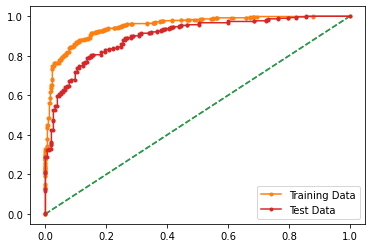

In [54]:
# AUC and ROC for the training data

gbcl_probs_train = gbcl.predict_proba(X_train)
gbcl_probs_train = gbcl_probs_train [:, 1]

auc=roc_auc_score(Y_train,gbcl_probs_train)
print("AUC for the Training Data in GradientBoost: %.2f " % auc)
fpr ,tpr, thresholds= roc_curve(Y_train,gbcl_probs_train)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

gbcl_probs_test = gbcl.predict_proba(X_test)
gbcl_probs_test = gbcl_probs_test[:,1]

auc=roc_auc_score(Y_test,gbcl_probs_test)
print("AUC for the Test Data in GradientBoost: %.2f " % auc)
fpr,tpr,threshold=roc_curve(Y_test,gbcl_probs_test)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr, tpr, marker='.',label = 'Test Data')

# show the plot
plt.legend(loc='best')
plt.show()

# THE END